<a href="https://colab.research.google.com/github/Tej1109/MLP_Pracs/blob/main/Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [158]:
from sklearn.experimental import enable_iterative_imputer  #using iterative imputer for regression imputing

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

# For ANN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import shap
import joblib
import os


### EDA

In [159]:
df = pd.read_csv("/content/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [160]:
df.shape

(5110, 12)

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [162]:
#Gets us the categorical columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

BMI contains nulls, we will have to handle this, let's see how many



In [163]:
#Statistical Overview:
display(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,5110.0,NaN,NaN,NaN,36517.829354,21161.721625,67.0,17741.25,36932.0,54682.0,72940.0
gender,5110,3,Female,2994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,5110.0,NaN,NaN,NaN,43.226614,22.612647,0.08,25.0,45.0,61.0,82.0
hypertension,5110.0,NaN,NaN,NaN,0.097456,0.296607,0.0,0.0,0.0,0.0,1.0
heart_disease,5110.0,NaN,NaN,NaN,0.054012,0.226063,0.0,0.0,0.0,0.0,1.0
ever_married,5110,2,Yes,3353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
work_type,5110,5,Private,2925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Residence_type,5110,2,Urban,2596,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_glucose_level,5110.0,NaN,NaN,NaN,106.147677,45.28356,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,NaN,NaN,NaN,28.893237,7.854067,10.3,23.5,28.1,33.1,97.6


The NaNs are for numerical binary columns, and the stats do not apply on them

In [164]:
df.isna().sum() #201 nulls

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


#### Target Distribution

In [165]:
df['stroke'].value_counts()

,count
stroke,
0,4861
1,249


In [166]:
df['stroke'].value_counts(normalize=True) * 100

,proportion
stroke,
0,95.127202
1,4.872798


Approx 95% of our dataset contains datapoints of No Stroke, while stroke is being represented by the other 5%,
Thus, this data has high class imbalance, and this is an issue which we will have to deal in order to make a good generalizable model.

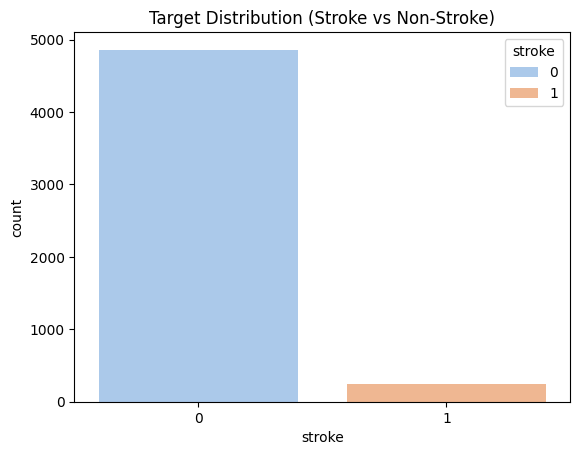

In [167]:
sns.countplot(x='stroke', data=df,hue = 'stroke',palette = 'pastel')
plt.title('Target Distribution (Stroke vs Non-Stroke)')
plt.show()

#### Correlation Heatmap

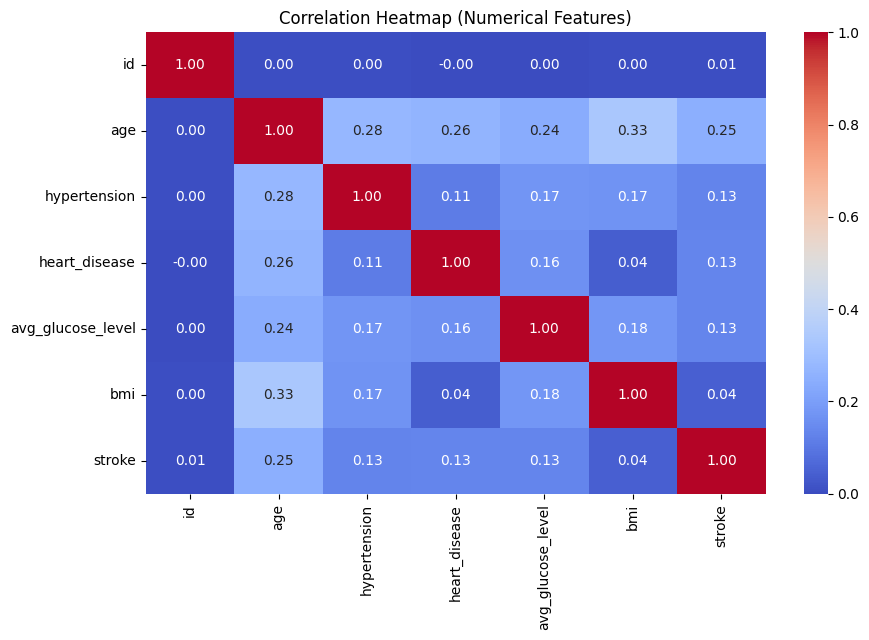

In [168]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

In [169]:
df.drop("id", axis = 1,inplace = True)
num_cols.remove("id")

An interesting correlation here is of age with the remaining numerical features that are mostly conditions that occur as you grow older

#### Boxplots
To check outliers and distribution of dataset features

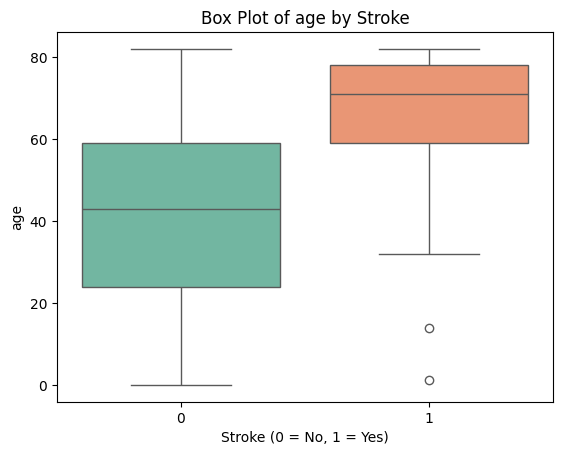

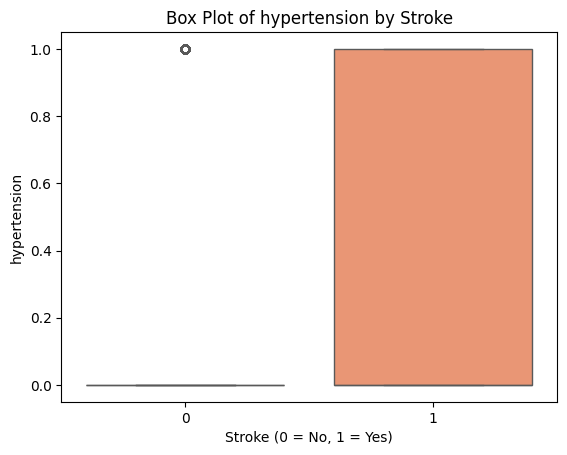

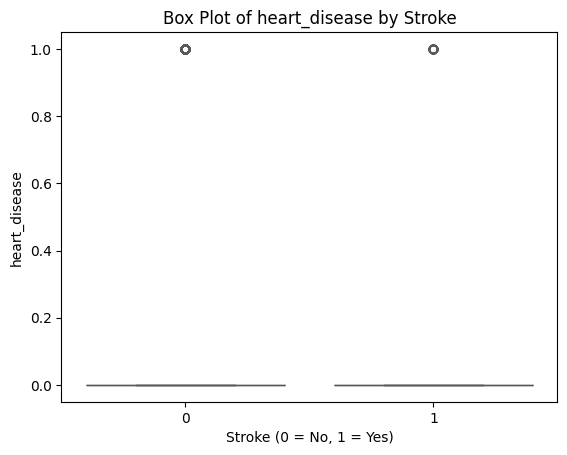

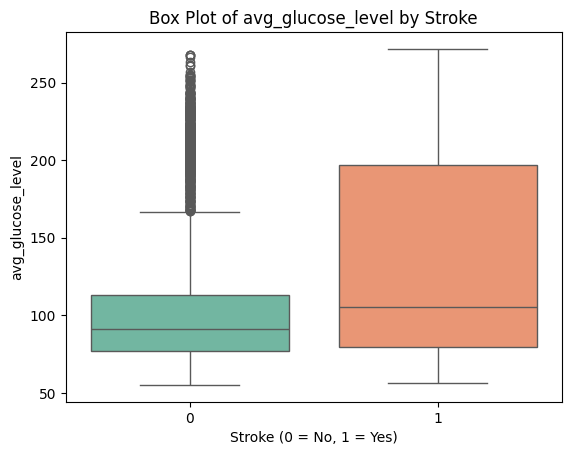

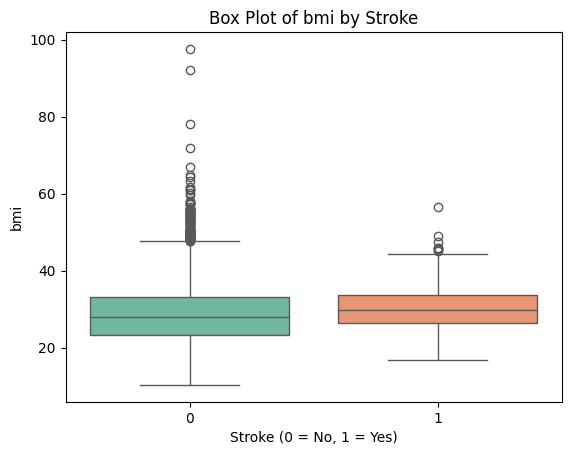

In [170]:
num_cols.remove('stroke')  # exclude target column

for i, col in enumerate(num_cols, 1):
    sns.boxplot(x='stroke', y=col, data=df, palette='Set2')
    plt.title(f'Box Plot of {col} by Stroke')
    plt.xlabel('Stroke (0 = No, 1 = Yes)')
    plt.ylabel(col)
    plt.show()



There are some outliers for 2 cols:
 - avg_glucose_level
 - bmi


#### Basic Data Cleaning
Here we will be removing Missing values from bmi
There are mainly 3 ways
 - Dropping Null rows
 - Simple Imputation with Mean/median/mode
 - Iterative Imputing - Creating a Regression Model to predict bmi from the remaining features.


In [171]:
#First Approach
df_dropna = df.dropna(subset=['bmi']).copy()
df_dropna["stroke"].value_counts() #Here we lost 40 important rows of stroke == 1, this cannot be our best approach

,count
stroke,
0,4700
1,209


In [172]:
skewness = df['bmi'].skew()
skewness

np.float64(1.0553402052962912)

In [173]:
strategy = 'median'
#Median bcz we have outliers as we saw in boxplot
imputer = SimpleImputer(strategy=strategy)
df_simple_imputed = df.copy()
df_simple_imputed[['bmi']] = imputer.fit_transform(df[['bmi']])
df_simple_imputed["stroke"].value_counts()

,count
stroke,
0,4861
1,249


In [174]:
imp_iter = IterativeImputer(random_state=42)
df_iterative_imputed = df.copy()
df_iterative_imputed[['bmi']] = imp_iter.fit_transform(df[['bmi']])
df_iterative_imputed["stroke"].value_counts()

,count
stroke,
0,4861
1,249


### Basic Modeling
In this section we will run some baseline models and check their performance on the dataset

#### On Simple Imputed Dataset

In [175]:
#Train Test Split
X = df_simple_imputed.drop('stroke', axis=1)
y = df_simple_imputed['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [176]:
#Preprocessing pipeline:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])


In [177]:
df_simple_imputed.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [178]:
X

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked
...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked


In [179]:
!pip install catboost

In [180]:

from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, recall_score, average_precision_score
def train_baseline_models(X_train, X_test, y_train, y_test, preprocessor):
    models_base = {
        "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Naive Bayes": GaussianNB(),
        "Bagging": BaggingClassifier(random_state=42),
        "AdaBoost Decision Stump": AdaBoostClassifier(random_state=42),
        "AdaBoost Linear" : AdaBoostClassifier( estimator=LogisticRegression(max_iter=2000, random_state=42), n_estimators=100,learning_rate=0.1,random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
    }

    results = []

    for name, model in models_base.items():
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_proba = pipe.predict_proba(X_test)[:, 1]

        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        pr_auc = average_precision_score(y_test, y_proba)

        results.append({
            "Model": name,
            "F1": f1,
            "Recall": recall,
            "PR-AUC": pr_auc
        })

    # ANN separately (no sklearn pipeline)
    X_train_proc = preprocessor.fit_transform(X_train)
    X_test_proc = preprocessor.transform(X_test)

    ann = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(X_train_proc.shape[1],)),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])

    ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    ann.fit(X_train_proc, y_train, validation_split=0.1, epochs=30, batch_size=32, verbose=0)

    y_proba_ann = ann.predict(X_test_proc).ravel()
    y_pred_ann = (y_proba_ann >= 0.5).astype(int)

    f1 = f1_score(y_test, y_pred_ann)
    recall = recall_score(y_test, y_pred_ann)
    pr_auc = average_precision_score(y_test, y_proba_ann)

    results.append({
        "Model": "ANN",
        "F1": f1,
        "Recall": recall,
        "PR-AUC": pr_auc
    })

    results_df = pd.DataFrame(results).sort_values(by='PR-AUC', ascending=False).reset_index(drop=True)
    return results_df

In [181]:
baseline_df_simple_imputed = train_baseline_models(X_train, X_test, y_train, y_test, preprocessor)
baseline_df_simple_imputed

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,Model,F1,Recall,PR-AUC
0,Logistic Regression,0.039216,0.02,0.270958
1,ANN,0.039216,0.02,0.249171
2,AdaBoost Linear,0.076923,0.04,0.229992
3,AdaBoost Decision Stump,0.000000,0.00,0.225252
4,Gradient Boosting,0.037037,0.02,0.196695
5,CatBoost,0.133333,0.08,0.186300
6,XGBoost,0.096774,0.06,0.180432
7,Naive Bayes,0.120245,0.98,0.169621
8,Random Forest,0.035088,0.02,0.146907
9,Bagging,0.032787,0.02,0.110325


In [182]:
#Train Test Split
X = df_iterative_imputed.drop('stroke', axis=1)
y = df_iterative_imputed['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [183]:
baseline_df_iteratively_imputed = train_baseline_models(X_train, X_test, y_train, y_test, preprocessor)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [184]:
baseline_df_iteratively_imputed

,Model,F1,Recall,PR-AUC
0,Logistic Regression,0.039216,0.02,0.270154
1,ANN,0.039216,0.02,0.244381
2,AdaBoost Linear,0.076923,0.04,0.228815
3,AdaBoost Decision Stump,0.000000,0.00,0.211794
4,CatBoost,0.175439,0.10,0.206953
5,Gradient Boosting,0.000000,0.00,0.193621
6,Naive Bayes,0.120541,0.98,0.169483
7,XGBoost,0.098361,0.06,0.167458
8,Random Forest,0.000000,0.00,0.137446
9,Bagging,0.035714,0.02,0.105813


Here we can see, Linear models are surely learning some patterns,yet the class imbalance truly dominates the  performance,Tree models are dying here, the sole reason? the inability to extrapolate, the imbalanced class is totally overruling any decision made in trees.

#### Handling Class Imbalance

In [185]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.metrics import f1_score, recall_score, average_precision_score
from imblearn.pipeline import Pipeline as ImbPipeline
from itertools import product

def smote_model_experiments(X_train, X_test, y_train, y_test, preprocessor):
    smote_params = {
        "SMOTE": {"k_neighbors": [3, 5, 7],
                  "sampling_strategy": [0.5, 0.7, 1.0]},
        "BorderlineSMOTE": {"k_neighbors": [3, 5],
                            "kind": ["borderline-1", "borderline-2"]},
        "ADASYN": {"n_neighbors": [3, 5, 7],
                   "sampling_strategy": [0.5, 0.7, 1.0]}
    }

    models = {
        "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "AdaBoost (Linear)": AdaBoostClassifier(
            estimator=LogisticRegression(max_iter=2000, random_state=42),
            n_estimators=100, learning_rate=0.5, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
    }

    results = []

    for method, params in smote_params.items():
        keys, values = zip(*params.items())
        for combo in product(*values):
            param_dict = dict(zip(keys, combo))

            if method == "SMOTE":
                sampler = SMOTE(random_state=42, **param_dict)
            elif method == "BorderlineSMOTE":
                sampler = BorderlineSMOTE(random_state=42, **param_dict)
            else:
                sampler = ADASYN(random_state=42, **param_dict)

            for model_name, model in models.items():
                pipe = ImbPipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('balancer', sampler),
                    ('classifier', model)
                ])

                pipe.fit(X_train, y_train)
                y_pred = pipe.predict(X_test)
                y_proba = pipe.predict_proba(X_test)[:, 1]

                f1 = f1_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                pr_auc = average_precision_score(y_test, y_proba)

                results.append({
                    "Model": model_name,
                    "Method": method,
                    **param_dict,
                    "F1": f1,
                    "Recall": recall,
                    "PR-AUC": pr_auc
                })

    df_results = pd.DataFrame(results).sort_values(by="PR-AUC", ascending=False).reset_index(drop=True)
    return df_results


In [187]:
smote_model_results = smote_model_experiments(X_train, X_test, y_train, y_test, preprocessor)
display()


In [188]:
smote_model_results

,Model,Method,k_neighbors,sampling_strategy,F1,Recall,PR-AUC,kind,n_neighbors
0,Logistic Regression,ADASYN,NaN,0.7,0.267606,0.76,0.297326,NaN,7.0
1,Logistic Regression,ADASYN,NaN,1.0,0.234604,0.80,0.296392,NaN,7.0
2,Logistic Regression,ADASYN,NaN,1.0,0.235294,0.80,0.295952,NaN,5.0
3,Logistic Regression,SMOTE,7.0,1.0,0.241692,0.80,0.291152,NaN,NaN
4,Logistic Regression,ADASYN,NaN,0.7,0.265734,0.76,0.291119,NaN,5.0
...,...,...,...,...,...,...,...,...,...
105,Random Forest,ADASYN,NaN,0.7,0.121951,0.10,0.125699,NaN,5.0
106,Random Forest,SMOTE,7.0,1.0,0.137931,0.12,0.123954,NaN,NaN
107,Random Forest,SMOTE,3.0,1.0,0.153846,0.14,0.123707,NaN,NaN
108,Random Forest,ADASYN,NaN,0.5,0.126582,0.10,0.123085,NaN,5.0


In [189]:
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import f1_score, recall_score, average_precision_score
import pandas as pd

def compare_resampling_configs(X_train, X_test, y_train, y_test, preprocessor):
    configs = {
        "SMOTE (k=7, s=0.5)": SMOTE(k_neighbors=7, sampling_strategy=0.5, random_state=42),
        "ADASYN (n=3, s=1.0)": ADASYN(n_neighbors=3, sampling_strategy=1.0, random_state=42)
    }

    base_models = {
        "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
        "AdaBoost (Linear)": AdaBoostClassifier(
            estimator=LogisticRegression(max_iter=2000, random_state=42),
            n_estimators=100, learning_rate=0.5, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
    }

    results = []

    for conf_name, sampler in configs.items():
        # preprocess + balance
        X_train_proc = preprocessor.fit_transform(X_train)
        X_test_proc = preprocessor.transform(X_test)
        X_train_bal, y_train_bal = sampler.fit_resample(X_train_proc, y_train)

        for name, model in base_models.items():
            model.fit(X_train_bal, y_train_bal)
            y_pred = model.predict(X_test_proc)
            y_proba = model.predict_proba(X_test_proc)[:, 1]

            f1 = f1_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            pr_auc = average_precision_score(y_test, y_proba)

            results.append({
                "Resampler": conf_name,
                "Model": name,
                "F1": f1,
                "Recall": recall,
                "PR-AUC": pr_auc
            })

        # --- ANN separately ---
        ann = models.Sequential([
            layers.Dense(64, activation='relu', input_shape=(X_train_bal.shape[1],)),
            layers.Dropout(0.3),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(1, activation='sigmoid')
        ])
        ann.compile(optimizer='adam', loss='binary_crossentropy')
        ann.fit(X_train_bal, y_train_bal, epochs=25, batch_size=32, verbose=0)

        ann_proba = ann.predict(X_test_proc).ravel()
        ann_pred = (ann_proba >= 0.5).astype(int)

        f1 = f1_score(y_test, ann_pred)
        recall = recall_score(y_test, ann_pred)
        pr_auc = average_precision_score(y_test, ann_proba)

        results.append({
            "Resampler": conf_name,
            "Model": "ANN",
            "F1": f1,
            "Recall": recall,
            "PR-AUC": pr_auc
        })

    df = pd.DataFrame(results).sort_values(by=["Resampler","PR-AUC"], ascending=[True,False]).reset_index(drop=True)
    return df


In [190]:
dual_results = compare_resampling_configs(X_train, X_test, y_train, y_test, preprocessor)
display(dual_results)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Resampler,Model,F1,Recall,PR-AUC
0,"ADASYN (n=3, s=1.0)",Logistic Regression,0.232558,0.80,0.279263
1,"ADASYN (n=3, s=1.0)",ANN,0.209524,0.44,0.182360
2,"ADASYN (n=3, s=1.0)",AdaBoost (Linear),0.250784,0.80,0.168310
3,"ADASYN (n=3, s=1.0)",XGBoost,0.181818,0.18,0.154434
4,"ADASYN (n=3, s=1.0)",CatBoost,0.150538,0.14,0.144671
5,"SMOTE (k=7, s=0.5)",Logistic Regression,0.303797,0.72,0.279724
6,"SMOTE (k=7, s=0.5)",AdaBoost (Linear),0.305221,0.76,0.217216
7,"SMOTE (k=7, s=0.5)",ANN,0.223464,0.40,0.193841
8,"SMOTE (k=7, s=0.5)",XGBoost,0.166667,0.14,0.158721
9,"SMOTE (k=7, s=0.5)",CatBoost,0.144928,0.10,0.152992


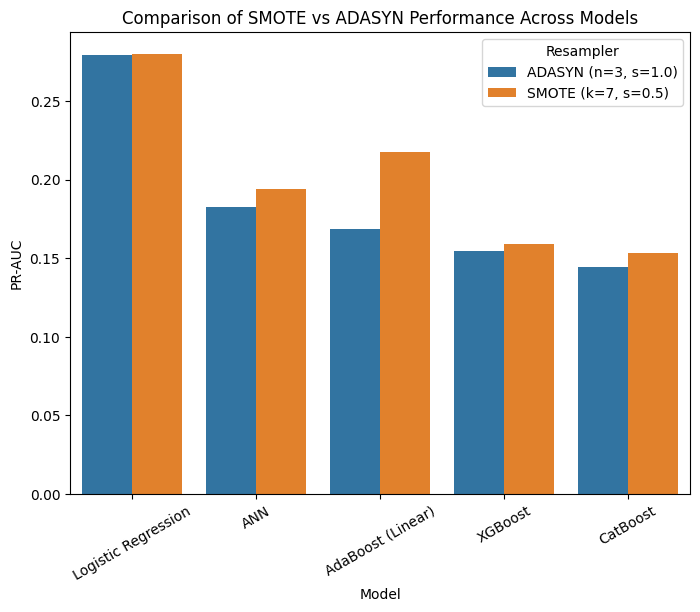

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.barplot(data=dual_results, x="Model", y="PR-AUC", hue="Resampler")
plt.title("Comparison of SMOTE vs ADASYN Performance Across Models")
plt.ylabel("PR-AUC")
plt.xticks(rotation=30)
plt.show()


Thus, we select SMOTE with k = 7, s = 0.5

In [216]:
# Keep your original dataset untouched
X_raw = X.copy()
y_raw = y.copy()


In [221]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, recall_score, average_precision_score
import numpy as np

def safe_pr_auc(y_true, y_proba, **kwargs):
    """Compute PR-AUC safely — never return NaN."""
    try:
        score = average_precision_score(y_true, y_proba)
        return np.nan_to_num(score, nan=0.0)
    except Exception:
        return 0.0

def tune_model(model, param_grid, model_name, preprocessor, search_type="auto"):
    """
    Hyperparameter tuning with:
      - SMOTE inside CV pipeline (no leakage)
      - Stratified 5-fold CV
      - Safe PR-AUC scorer
      - Automatic Grid/Random search selection
    """

    print(f"\nStarting tuning for: {model_name}")

    # Define stratified CV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Define scorers
    scorers = {
        "f1": make_scorer(f1_score),
        "recall": make_scorer(recall_score),
        "pr_auc": make_scorer(safe_pr_auc, needs_proba=True)
    }

    # Choose search type automatically
    if search_type == "auto":
        if model_name in ["Logistic Regression", "AdaBoost (Linear)"]:
            search_type = "grid"
        else:
            search_type = "random"

    # SMOTE inside the pipeline (runs per fold)
    smote_final = SMOTE(k_neighbors=7, sampling_strategy=0.5, random_state=42)

    pipe = ImbPipeline([
        ('preprocessor', preprocessor),
        ('balancer', smote_final),
        ('classifier', model)
    ])

    # Define search object
    if search_type == "grid":
        print(f"Using GridSearchCV for {model_name}")
        searcher = GridSearchCV(
            pipe,
            param_grid=param_grid,
            scoring=scorers,
            refit="pr_auc",
            cv=cv,
            n_jobs=-1,
            verbose=1,
            error_score='raise'
        )
    else:
        print(f"Using RandomizedSearchCV for {model_name}")
        searcher = RandomizedSearchCV(
            pipe,
            param_distributions=param_grid,
            n_iter=20,
            scoring=scorers,
            refit="pr_auc",
            cv=cv,
            n_jobs=-1,
            random_state=42,
            verbose=1,
            error_score='raise'
        )

    # Fit the search safely
    try:
        searcher.fit(X, y)
        print(f"Best Params: {searcher.best_params_}")
        print(f"Best PR-AUC: {searcher.best_score_:.4f}")
    except Exception as e:
        print(f"Error during tuning for {model_name}: {e}")
        return None, None

    return searcher.best_estimator_, searcher


In [224]:
#Logistic CV
best_log, grid_log = tune_model(
    LogisticRegression(max_iter=2000, random_state=42),
    {
        "classifier__C": [0.1, 0.5, 1, 5, 10],
        "classifier__solver": ["lbfgs","liblinear"]
    },
    "Logistic Regression",
    preprocessor
)



Starting tuning for: Logistic Regression
Using GridSearchCV for Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Params: {'classifier__C': 0.1, 'classifier__solver': 'lbfgs'}
Best PR-AUC: 0.1254


In [225]:
best_rf, grid_rf = tune_model(
    RandomForestClassifier(random_state=42),
    {
        "classifier__n_estimators": [100, 200, 300],
        "classifier__max_depth": [5, 10, 15],
        "classifier__min_samples_split": [2, 5],
        "classifier__min_samples_leaf": [1, 2]
    },
    "Random Forest",
    preprocessor
)



Starting tuning for: Random Forest
Using RandomizedSearchCV for Random Forest
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 5}
Best PR-AUC: 0.0790


In [226]:
best_xgb_tree, grid_xgb_tree = tune_model(
    XGBClassifier(booster='gbtree', eval_metric='logloss', random_state=42, use_label_encoder=False),
    {
        "classifier__n_estimators": [200, 300],
        "classifier__max_depth": [3, 5, 7],
        "classifier__learning_rate": [0.05, 0.1, 0.2],
        "classifier__subsample": [0.8, 1.0],
        "classifier__colsample_bytree": [0.8, 1.0]
    },
    "XGBoost (Tree)",
    preprocessor
)



Starting tuning for: XGBoost (Tree)
Using RandomizedSearchCV for XGBoost (Tree)
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'classifier__subsample': 1.0, 'classifier__n_estimators': 200, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.8}
Best PR-AUC: 0.0642


In [227]:
best_xgb_lin, grid_xgb_lin = tune_model(
    XGBClassifier(booster='gblinear', eval_metric='logloss', random_state=42, use_label_encoder=False),
    {
        "classifier__lambda": [0, 1, 5],
        "classifier__alpha": [0, 1, 5],
        "classifier__learning_rate": [0.01, 0.1, 0.2]
    },
    "XGBoost (Linear)",
    preprocessor
)


Starting tuning for: XGBoost (Linear)
Using RandomizedSearchCV for XGBoost (Linear)
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'classifier__learning_rate': 0.1, 'classifier__lambda': 0, 'classifier__alpha': 0}
Best PR-AUC: 0.1250


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

base_lr = LogisticRegression(max_iter=2000, solver='lbfgs', random_state=42)

best_ada_lin, grid_ada_lin = tune_model(
    AdaBoostClassifier(estimator=base_lr, random_state=42),
    {
        "classifier__n_estimators": [50, 100, 200],
        "classifier__learning_rate": [0.5, 1.0, 1.5]
    },
    "AdaBoost (Linear)",
    preprocessor
)


Starting tuning for: AdaBoost (Linear)
Using GridSearchCV for AdaBoost (Linear)
Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [237]:
# FINAL EVALUATION — FULL PIPELINE (preprocess + SMOTE + model)

import pandas as pd
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, recall_score, precision_score,
    roc_auc_score, average_precision_score, classification_report
)

# --- Custom SMOTE that keeps column names ---
class SMOTEWithColumns(SMOTE):
    def fit_resample(self, X, y):
        X_res, y_res = super().fit_resample(X, y)
        if isinstance(X, pd.DataFrame):
            X_res = pd.DataFrame(X_res, columns=X.columns)
        return X_res, y_res


# --- Helper function to safely build clean pipelines ---
def build_clean_pipe(model, preprocessor):
    smote = SMOTEWithColumns(k_neighbors=7, sampling_strategy=0.5, random_state=42)

    # unwrap model if it’s already a pipeline
    if hasattr(model, "steps"):
        model = model.named_steps.get("classifier", model.steps[-1][1])

    pipe = ImbPipeline([
        ('preprocessor', preprocessor),
        ('balancer', smote),
        ('classifier', model)
    ])
    return pipe


# --- Load the iteratively imputed dataset ---
X = df_iterative_imputed.drop("stroke", axis=1).copy()
y = df_iterative_imputed["stroke"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

print("Data ready:", X_train.shape, X_test.shape)

# --- Your tuned models (ensure they exist from previous tuning) ---
final_models = {
    "Logistic Regression": best_log,
    "Random Forest": best_rf,
    "XGBoost (Tree)": best_xgb_tree,
    "XGBoost (Linear)": best_xgb_lin,
    "AdaBoost (Linear)": best_ada_lin
}

# --- Evaluate each model ---
results = []

for name, model in final_models.items():
    print(f"\nEvaluating {name}...")

    pipe = build_clean_pipe(model, preprocessor)
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    results.append({
        "Model": name,
        "F1": f1,
        "Recall": recall,
        "Precision": precision,
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
    })

# --- Results summary ---
results_df = pd.DataFrame(results).sort_values(by="PR-AUC", ascending=False)
print("\nFINAL TEST RESULTS")
print(results_df.round(4))

# --- Classification report for top model ---
best_model_name = results_df.iloc[0]["Model"]
print(f"\nCLASSIFICATION REPORT ({best_model_name})")

best_pipe = build_clean_pipe(final_models[best_model_name], preprocessor)
best_pipe.fit(X_train, y_train)
y_pred_best = best_pipe.predict(X_test)
print(classification_report(y_test, y_pred_best))

# --- Save the final pipeline for deployment ---
joblib.dump(best_pipe, f"stroke_prediction_{best_model_name.replace(' ', '_')}.pkl")
print(f"Saved: stroke_prediction_{best_model_name.replace(' ', '_')}.pkl")


Data ready: (4088, 10) (1022, 10)

Evaluating Logistic Regression...

Evaluating Random Forest...

Evaluating XGBoost (Tree)...

Evaluating XGBoost (Linear)...

Evaluating AdaBoost (Linear)...

FINAL TEST RESULTS
                 Model      F1  Recall  Precision  ROC-AUC  PR-AUC
0  Logistic Regression  0.3051    0.72     0.1935   0.8439  0.2756
3     XGBoost (Linear)  0.3090    0.72     0.1967   0.8443  0.2745
1        Random Forest  0.2406    0.32     0.1928   0.8189  0.2128
2       XGBoost (Tree)  0.1690    0.12     0.2857   0.8047  0.2050
4    AdaBoost (Linear)  0.2837    0.80     0.1724   0.8107  0.1800

CLASSIFICATION REPORT (Logistic Regression)
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       972
           1       0.19      0.72      0.31        50

    accuracy                           0.84      1022
   macro avg       0.59      0.78      0.61      1022
weighted avg       0.94      0.84      0.88      1022

Saved: stroke

In [238]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, average_precision_score
import pandas as pd

# we'll reuse X_train, X_test, y_train, y_test from before
# and the best individual model objects (best_log, best_xgb_lin, best_ada_lin)

# helper for evaluation
def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return {
        "Model": name,
        "F1": f1_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba),
        "PR-AUC": average_precision_score(y_test, y_proba)
    }

# 1. weighted soft-voting ensemble
voting = VotingClassifier(
    estimators=[
        ("log", best_log.named_steps["classifier"] if hasattr(best_log, "steps") else best_log),
        ("xgb_lin", best_xgb_lin.named_steps["classifier"] if hasattr(best_xgb_lin, "steps") else best_xgb_lin),
        ("ada_lin", best_ada_lin.named_steps["classifier"] if hasattr(best_ada_lin, "steps") else best_ada_lin)
    ],
    voting="soft",
    weights=[2, 2, 1]   # bias slightly toward the stronger linear models
)

voting_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('balancer', SMOTEWithColumns(k_neighbors=7, sampling_strategy=0.5, random_state=42)),
    ('classifier', voting)
])
voting_pipe.fit(X_train, y_train)
res_voting = evaluate_model("Weighted Voting", voting_pipe)

# 2. stacking ensemble (meta-learner = logistic regression)
stack = StackingClassifier(
    estimators=[
        ("log", best_log.named_steps["classifier"] if hasattr(best_log, "steps") else best_log),
        ("xgb_lin", best_xgb_lin.named_steps["classifier"] if hasattr(best_xgb_lin, "steps") else best_xgb_lin),
        ("ada_lin", best_ada_lin.named_steps["classifier"] if hasattr(best_ada_lin, "steps") else best_ada_lin)
    ],
    final_estimator=LogisticRegression(max_iter=2000, random_state=42),
    stack_method="predict_proba",
    n_jobs=-1
)

stack_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('balancer', SMOTEWithColumns(k_neighbors=7, sampling_strategy=0.5, random_state=42)),
    ('classifier', stack)
])
stack_pipe.fit(X_train, y_train)
res_stack = evaluate_model("Stacking Ensemble", stack_pipe)

# 3. compare all ensemble results
ensemble_results = pd.DataFrame([res_voting, res_stack]).sort_values(by="PR-AUC", ascending=False)
print("\nENSEMBLE RESULTS")
print(ensemble_results.round(4))



ENSEMBLE RESULTS
               Model      F1  Recall  Precision  ROC-AUC  PR-AUC
0    Weighted Voting  0.3051    0.72     0.1935   0.8440  0.2680
1  Stacking Ensemble  0.3090    0.72     0.1967   0.8436  0.2664
